# Chapter 15 – Weather Prediction
### <font color=blue>Neural Networks that predicts temperature using previous temperatures AND other data points</font>

## Import Modules

In [1]:
# Common imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#tensorflow imports
import tensorflow as tf
from tensorflow import keras

#sklearn imports
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import SGDRegressor, LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

## Function Definitions

In [2]:
#function to verify the existence of a file in the current working directory and download it if not
import os,urllib, urllib.request, sys, tarfile
def downloadDataResource(file, sourcePath, compressed=None):
    if not os.path.isfile(file):
        try:
            urllib.request.urlretrieve(sourcePath+(compressed if compressed else file),(compressed if compressed else file))
            print("Downloaded", (compressed if compressed else file) )
            if compressed:
                ucomp = tarfile.open(compressed)
                ucomp.extractall()
                ucomp.close()
                print("File uncompressed.")
        except:
            print("ERROR: File", (compressed if compressed else file), "not found. Data source missing.")
    else:
        print("Data resource", file, "already downloaded.")

In [3]:
#function provided that plots the learning curve for neural networks
def nn_plot_learning_curve( history ):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    ymin, ymax = [], []
    for x in history.history.keys():
        ymax.append( max(history.history[x]))
        ymin.append( min(history.history[x]))
    plt.gca().set_ylim(min(ymin)*.95, max(ymax)*1.05)
    plt.xlabel("EPOCHS")
    plt.show()

In [4]:
#function to plot actual values vs. predicted values
def plot_actual_pred( actual, prediction ):
    plt.plot(actual, ".-", alpha=.6, label="Actual")
    plt.plot(prediction, ".-", alpha=.6, label="Prediction")
    plt.grid(True)
    plt.legend()
    plt.show()

In [5]:
#function to plot a series as well as the predicted and value to be predicted (if known)
def plot_series(series, y=None, y_pred=None):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(range(series.shape[0], series.shape[0]+y.shape[0]), y, "bx-", markersize=10, label="Actual")
    if y_pred is not None:
        plt.plot(range(series.shape[0], series.shape[0]+y_pred.shape[0]), y_pred, "ro-", label="Prediction")
    plt.grid(True)
    plt.legend()
    plt.show()

## Source Data

In [6]:
#download data files if not currently found in your datasets directory (under the current working directory)
path = 'https://raw.githubusercontent.com/SueMcMetzger/MachineLearning/main/chpt15/'
filename = "VillanovaUniversityWeather.csv"

downloadDataResource(filename,path)

#create a dataframe with the data from the CSV file
data = pd.read_csv(filename)

Data resource VillanovaUniversityWeather.csv already downloaded.


In [7]:
#convert the date information to a date value
data['date'] = data['dt_iso'].apply(lambda x: x[0:20])
data['date']= pd.to_datetime(data['date'], errors='coerce', format='%Y-%m-%d %H:%M:%S')

In [8]:
#remove unnecessary data (but feel free to add back in data if you wish
data.drop(['dt_iso', 'rain_1h','rain_3h','snow_1h','snow_3h','temp_min','temp_max','clouds_all','weather_id','weather_main','weather_description'],axis=1,inplace=True)

## Filter Data (for speed)

In [9]:
#filter data so we are only seeing the temperature at 1 given hour in the day
#choose hour 5 which in EST time zone would be at mid-day
#feel free to comment out this filter and you will have hourly data to anlayze (as opposed to daily)
data = data[data['date'].dt.hour == 5]

#OR limited data to 2 years worth - feel free to change this if you want to look at more years
data = data[data['date'].dt.year > 2018 ]

In [10]:
#set the date field as the index
data.set_index('date',inplace = True)
data.drop_duplicates(inplace=True)  #There appears to be some duplicates!

In [11]:
#let's look at the first few instances
data.head()

,temp,feels_like,pressure,humidity,wind_speed,wind_deg
date,,,,,,
2019-01-01 05:00:00,46.51,43.81,1008,100,3.36,200
2019-01-02 05:00:00,40.37,34.30,1023,75,4.70,295
2019-01-03 05:00:00,39.16,32.68,1007,86,6.08,160
2019-01-04 05:00:00,30.07,23.77,1011,100,4.36,247
2019-01-05 05:00:00,42.22,38.01,996,100,4.32,43


## Prepare the Data

#### This code assumes that the data is in chronological order (i.e. ascending).

In [12]:
#scale the data using MinMaxScaler
#challenge here is that we need to preserve the scaler used on the labeled data for future predictions

#scaler used for X features
xScaler = MinMaxScaler()
xScaled = xScaler.fit_transform(data.drop(columns=['temp']))

#scaler for Y feature
yScaler = MinMaxScaler()
yScaled = yScaler.fit_transform(data[['temp']])

#let's se what we now have
xScaled.shape, yScaled.shape

((732, 5), (732, 1))

In [13]:
#NOTE that we want to include Y as part of X to use it to predisct the next Y
scaled_data = np.concatenate( [ yScaled, xScaled], axis=1)
scaled_data.shape

(732, 6)

In [14]:
#added during class
scaled_data[0:5]

array([[0.54546619, 0.53238927, 0.38461538, 1.        , 0.18142077,
        0.55555556],
       [0.46682889, 0.43687858, 0.67307692, 0.63768116, 0.25464481,
        0.81944444],
       [0.45133197, 0.42060862, 0.36538462, 0.79710145, 0.33005464,
        0.44444444],
       [0.33491291, 0.33112383, 0.44230769, 1.        , 0.23606557,
        0.68611111],
       [0.49052254, 0.4741388 , 0.15384615, 1.        , 0.23387978,
        0.11944444]])

In [15]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#The samples are the number of rows. Timestep is how many previous predictions are to be used to calculate future predictions.
#Features is simply the number of columns/features in the training dataset.

FEATURES = scaled_data.shape[1]  #the number of features/dimensions in the data set
STEPS = 5                        #the timestep used to predict   #use the past 5 days to predict 1 day in the future
FUTURE = 1                       #how many days in the future to predict

#steps should be greater than or equal to future

In [16]:
#Empty lists to be populated using formatted training data
trainX = []
trainY = []

#Reformat input data into a shape: (n_samples x timesteps x features)
for i in range(STEPS, len(scaled_data) - FUTURE + 1):
    trainX.append(scaled_data[i - STEPS     :i         , 0:scaled_data.shape[1] ] )
    trainY.append(scaled_data[i + FUTURE - 1:i + FUTURE, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

trainX.shape, trainY.shape

((727, 5, 6), (727, 1))

In [17]:
#added from class
trainX[0]

array([[0.54546619, 0.53238927, 0.38461538, 1.        , 0.18142077,
        0.55555556],
       [0.46682889, 0.43687858, 0.67307692, 0.63768116, 0.25464481,
        0.81944444],
       [0.45133197, 0.42060862, 0.36538462, 0.79710145, 0.33005464,
        0.44444444],
       [0.33491291, 0.33112383, 0.44230769, 1.        , 0.23606557,
        0.68611111],
       [0.49052254, 0.4741388 , 0.15384615, 1.        , 0.23387978,
        0.11944444]])

In [18]:
#added from class
trainY[0]

array([0.48014857])

### Save FUTURE data points to predict

In [19]:
#For demonstrations purposes, keep the predictions aside so you can evaluate the results
toPredict = trainX[-FUTURE:].copy()
prediction = trainY[-FUTURE:].copy()
prediction = yScaler.inverse_transform( prediction )

#remove future predictions from dataset
trainX = trainX[:-FUTURE].copy()
trainY = trainY[:-FUTURE].copy()

trainX.shape, trainY.shape, toPredict.shape, prediction.shape
#726 rows, 5 by 6 (its going to learn from 5 sets of 6 features, 5 sequential examples that has 6 features)

((726, 5, 6), (726, 1), (1, 5, 6), (1, 1))

#### Create Test by splitting the training data sets

In [20]:
#split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(trainX, 
                                                    trainY, 
                                                    test_size=0.2, 
                                                    shuffle = False)
X_train.shape,  y_train.shape, X_test.shape,  y_test.shape

((580, 5, 6), (580, 1), (146, 5, 6), (146, 1))

In [21]:
#explore what a single time series looks likes (at least just the first 3 entries)
for i in range(3):
    print('{:} => {:}'.format(X_train[i], y_train[i]) )

[[0.54546619 0.53238927 0.38461538 1.         0.18142077 0.55555556]
 [0.46682889 0.43687858 0.67307692 0.63768116 0.25464481 0.81944444]
 [0.45133197 0.42060862 0.36538462 0.79710145 0.33005464 0.44444444]
 [0.33491291 0.33112383 0.44230769 1.         0.23606557 0.68611111]
 [0.49052254 0.4741388  0.15384615 1.         0.23387978 0.11944444]] => [0.48014857]
[[0.46682889 0.43687858 0.67307692 0.63768116 0.25464481 0.81944444]
 [0.45133197 0.42060862 0.36538462 0.79710145 0.33005464 0.44444444]
 [0.33491291 0.33112383 0.44230769 1.         0.23606557 0.68611111]
 [0.49052254 0.4741388  0.15384615 1.         0.23387978 0.11944444]
 [0.48014857 0.46620468 0.17307692 0.89855072 0.18142077 0.69444444]] => [0.37512807]
[[0.45133197 0.42060862 0.36538462 0.79710145 0.33005464 0.44444444]
 [0.33491291 0.33112383 0.44230769 1.         0.23606557 0.68611111]
 [0.49052254 0.4741388  0.15384615 1.         0.23387978 0.11944444]
 [0.48014857 0.46620468 0.17307692 0.89855072 0.18142077 0.69444444]


## Computing Some Baselines

<font color=blue>Naive Forecasting</font>: just use the last observed value in the series to predict the next value in the series

In [22]:
#predcition is based on last observed value
pred= yScaler.inverse_transform( y_test[:-1] )
actual= yScaler.inverse_transform( y_test[1:] )

#calculate the Mean Squared Error between the prediction and the actual
naive = mean_squared_error(pred, actual, squared=False)
print( 'Naive ERROR: {:.4f}'.format(naive) )

Naive ERROR: 7.5515


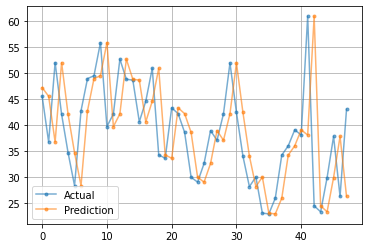

In [23]:
#plot the last 48 instances in the series to see the "predicted" shift in temperatures 
plot_actual_pred (actual[-48:], pred[-48:])

## Linear predictions using a simple Neural Network

In [24]:
#starting by setting random seeds and restarting keras blackend session
np.random.seed(42)
tf.random.set_seed(42)

#resets the Keras global state - helps avoid clutter from old models and layers, especially when memory is limited
keras.backend.clear_session()

In [25]:
#define early stopping
#this is not necessary BUT helps models run faster
#define what early stopping means - in this case, when the validation loss after 2 iterations hasn't changed
#after defining, it can be added to any model fitting using the parameter callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", 
                                               patience=2, 
                                               mode='min')

In [26]:
#create a simple linear neural network
model = keras.models.Sequential([
    keras.layers.Flatten(),
    keras.layers.Dense(1)
])

In [27]:
#compile and fit the model
#note we are using the metric Mean Squared Error for tempertatures
model.compile(loss="mean_squared_error", 
              optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
             )

In [28]:
#fit the model 
#NOTE: Because we are workign with a continuous series, shuffle=False is needed
history = model.fit(X_train, y_train, 
                    epochs=500, 
                    batch_size=STEPS,
                    validation_split=.2, 
                    shuffle=False, 
                    #Order matters so it cannot be random
                    callbacks=[early_stopping])

Epoch 1/500
93/93 [==============================] - 1s 2ms/step - loss: 0.3365 - val_loss: 0.4010
Epoch 2/500
93/93 [==============================] - 0s 1ms/step - loss: 0.2155 - val_loss: 0.2662
Epoch 3/500
93/93 [==============================] - 0s 2ms/step - loss: 0.1395 - val_loss: 0.1793
Epoch 4/500
93/93 [==============================] - 0s 2ms/step - loss: 0.0954 - val_loss: 0.1261
Epoch 5/500
93/93 [==============================] - 0s 1ms/step - loss: 0.0718 - val_loss: 0.0948
Epoch 6/500
93/93 [==============================] - 0s 1ms/step - loss: 0.0602 - val_loss: 0.0771
Epoch 7/500
93/93 [==============================] - 0s 1ms/step - loss: 0.0549 - val_loss: 0.0671
Epoch 8/500
93/93 [==============================] - 0s 1ms/step - loss: 0.0526 - val_loss: 0.0615
Epoch 9/500
93/93 [==============================] - 0s 1ms/step - loss: 0.0514 - val_loss: 0.0582
Epoch 10/500
93/93 [==============================] - 0s 1ms/step - loss: 0.0508 - val_loss: 0.0562
Epoch 11/

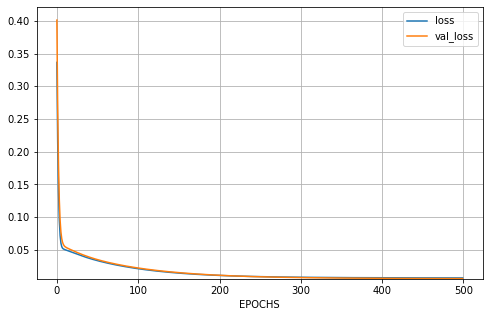

In [29]:
#see that the learning curve is healthy
nn_plot_learning_curve( history )

In [30]:
#predict the training data set
y_pred = model.predict(X_train)

#scale predicted and actuals
pred = yScaler.inverse_transform( y_pred )
actual = yScaler.inverse_transform( y_train )

#calculate the Mean Squared Error using the scaled values
error = mean_squared_error(pred, actual, squared=False)
print( 'ERROR: {:.4f}'.format(error) )

ERROR: 6.4765


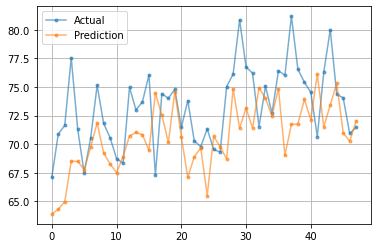

In [31]:
#plot the actuals vs. the predictions
plot_actual_pred ( actual[-48:], pred[-48:] )

ERROR: 6.0997


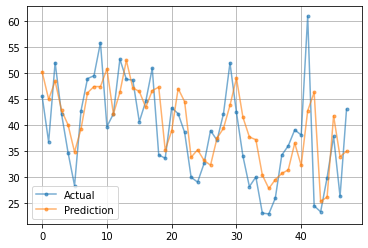

In [32]:
#predict the test data
y_pred = model.predict(X_test)

#scale predicted and actuals
pred = yScaler.inverse_transform( y_pred )
actual = yScaler.inverse_transform( y_test )

#calculate the Mean Squared Error using the scaled values
error = mean_squared_error(pred, actual, squared=False)
print( 'ERROR: {:.4f}'.format(error) )

#plot the actuals vs. the predictions

plot_actual_pred ( actual[-48:], pred[-48:] )

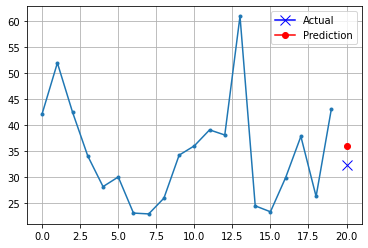

In [33]:
#Predict using the model
y_prediction = model.predict( toPredict )

#scale the y values
y_prediction = yScaler.inverse_transform( y_prediction )

#plot the actual values as well as future known actuals vs. future predictions
#NOTE: if FUTURES is > 1, the ,0 is needed to only plot the 1st value in the prediction
plot_series(actual[-20:], prediction, y_prediction[:,0]) 

In [34]:
#print the error
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

3.6173825073242156

## Make a Deep `SimpleRNN` 

In [35]:
#starting by setting random seeds and restarting keras blackend session
np.random.seed(42)
tf.random.set_seed(42)

#resets the Keras global state - helps avoid clutter from old models and layers, especially when memory is limited
keras.backend.clear_session()

In [36]:
#this is a very similar model to the last one but will run faster and provides flexibility in the output layer
model = keras.models.Sequential([
    keras.layers.SimpleRNN(10, return_sequences=True, input_shape=[None, FEATURES] ), 
                                #do you want to send it a multidemention when going through the layers
    keras.layers.SimpleRNN(8),
    keras.layers.Dense(1)
])

In [37]:
#compile the model
model.compile(loss="mean_squared_error", 
              optimizer=keras.optimizers.Adam(learning_rate=.0001), 
             )

#fit the model, using a callback defined earlier
history = model.fit(X_train, y_train, 
                    epochs=500,
                    batch_size=STEPS,
                    validation_split=.2, 
                    shuffle=False, 
                    callbacks=[early_stopping]
                   )

Epoch 1/500
93/93 [==============================] - 2s 5ms/step - loss: 0.2468 - val_loss: 0.2524
Epoch 2/500
93/93 [==============================] - 0s 3ms/step - loss: 0.1571 - val_loss: 0.1517
Epoch 3/500
93/93 [==============================] - 0s 3ms/step - loss: 0.1228 - val_loss: 0.1101
Epoch 4/500
93/93 [==============================] - 0s 3ms/step - loss: 0.1031 - val_loss: 0.0874
Epoch 5/500
93/93 [==============================] - 0s 3ms/step - loss: 0.0901 - val_loss: 0.0729
Epoch 6/500
93/93 [==============================] - 0s 3ms/step - loss: 0.0807 - val_loss: 0.0628
Epoch 7/500
93/93 [==============================] - 0s 3ms/step - loss: 0.0735 - val_loss: 0.0553
Epoch 8/500
93/93 [==============================] - 0s 3ms/step - loss: 0.0677 - val_loss: 0.0495
Epoch 9/500
93/93 [==============================] - 0s 3ms/step - loss: 0.0628 - val_loss: 0.0448
Epoch 10/500
93/93 [==============================] - 0s 3ms/step - loss: 0.0585 - val_loss: 0.0409
Epoch 11/

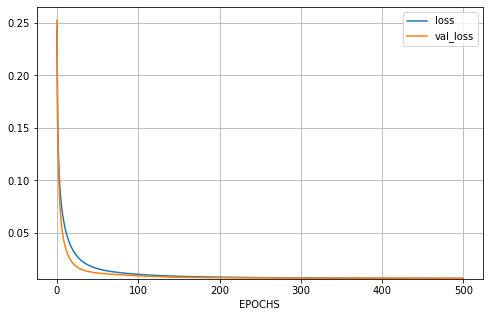

In [38]:
#plot the learning curve of the model
nn_plot_learning_curve(history)
plt.show()

In [39]:
#predict the training data set
y_pred = model.predict(X_train)

#scale predictions and actuals
pred = yScaler.inverse_transform( y_pred )
actual = yScaler.inverse_transform( y_train )

#calculate the Mean Squared Error using the scaled values
error = mean_squared_error(pred, actual, squared=False)
print( 'ERROR: {:.4f}'.format(error) )

ERROR: 6.4561


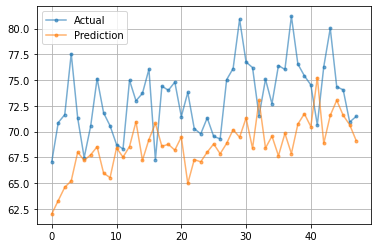

In [40]:
#plot the predictions vs. the actuals
plot_actual_pred( actual[-48:], pred[-48:] )

In [41]:
#predict the validation data set
y_pred = model.predict(X_test)

#scale predictiond and actuals
pred = yScaler.inverse_transform( y_pred )
actual = yScaler.inverse_transform( y_test )

#calculate the Mean Squared Error using the scaled values
error = mean_squared_error(pred, actual, squared=False)
print( 'ERROR: {:.4f}'.format(error) )

ERROR: 6.2750


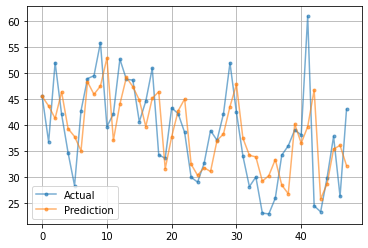

In [42]:
#plot the predictions vs. the actuals
plot_actual_pred( actual[-48:], pred[-48:] )

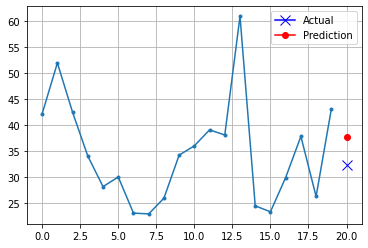

In [43]:
#Predict using the model
y_prediction = model.predict( toPredict )

#scale the y values
y_prediction = yScaler.inverse_transform( y_prediction )

#plot the actual values as well as future known actuals vs. future predictions
#NOTE: if FUTURES is > 1, the ,0 is needed to only plot the 1st value in the prediction
plot_series(actual[-20:], prediction, y_prediction[:,0]) 

In [44]:
#print the error
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

5.4001393127441375

# LSTM/GRU

In [45]:
#starting by setting random seeds and restarting keras blackend session
np.random.seed(42)
tf.random.set_seed(42)

#resets the Keras global state - helps avoid clutter from old models and layers, especially when memory is limited
keras.backend.clear_session()

In [46]:
X_train.shape

(580, 5, 6)

In [47]:
#now let's try this using LSTMs which by its nature takes into consideration 
#long-term trends as well as learning from newer data
#we just changed our RNN layers to LSTM layers

model = keras.models.Sequential([
    #dont want to flatten because we need to keep the data in sequence
    #we already have the data in the right order, for RNN
    keras.layers.LSTM(6, return_sequences=True, input_shape=[None, FEATURES] ),
    keras.layers.Dropout(.2),
    #ignore some neurons to make the model less complex
    #adding in regularization
    keras.layers.LSTM(6, return_sequences=True, input_shape=[None, FEATURES] ),
    keras.layers.LSTM(6),
    #return_sequences should be set to true for every layer except the layer before the last
    keras.layers.Dense(FUTURE)
])

In [48]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 6)           312       
                                                                 
 dropout (Dropout)           (None, None, 6)           0         
                                                                 
 lstm_1 (LSTM)               (None, None, 6)           312       
                                                                 
 lstm_2 (LSTM)               (None, 6)                 312       
                                                                 
 dense (Dense)               (None, 1)                 7         
                                                                 
Total params: 943
Trainable params: 943
Non-trainable params: 0
_________________________________________________________________


In [49]:
#compile the model
model.compile(loss="mean_squared_error", 
              optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
             )
#fit the model, using a callback defined earlier
history = model.fit(X_train,y_train, 
                    epochs=500,
                    batch_size=STEPS,
                    shuffle=False, 
                    validation_split=.2, 
                    callbacks=[early_stopping])

Epoch 1/500
93/93 [==============================] - 7s 18ms/step - loss: 0.3315 - val_loss: 0.5143
Epoch 2/500
93/93 [==============================] - 1s 7ms/step - loss: 0.2858 - val_loss: 0.4438
Epoch 3/500
93/93 [==============================] - 1s 7ms/step - loss: 0.2321 - val_loss: 0.3578
Epoch 4/500
93/93 [==============================] - 1s 7ms/step - loss: 0.1696 - val_loss: 0.2595
Epoch 5/500
93/93 [==============================] - 1s 8ms/step - loss: 0.1088 - val_loss: 0.1664
Epoch 6/500
93/93 [==============================] - 1s 8ms/step - loss: 0.0678 - val_loss: 0.1013
Epoch 7/500
93/93 [==============================] - 1s 8ms/step - loss: 0.0465 - val_loss: 0.0681
Epoch 8/500
93/93 [==============================] - 1s 8ms/step - loss: 0.0400 - val_loss: 0.0540
Epoch 9/500
93/93 [==============================] - 1s 10ms/step - loss: 0.0380 - val_loss: 0.0481
Epoch 10/500
93/93 [==============================] - 1s 8ms/step - loss: 0.0362 - val_loss: 0.0455
Epoch 1

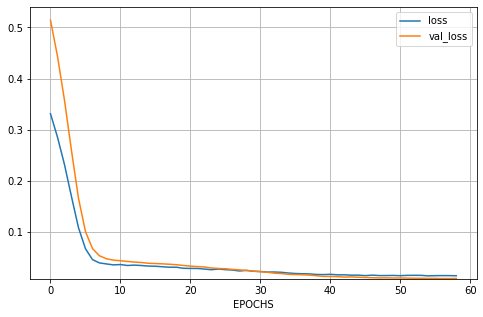

In [50]:
#plot the learning curve of the model
nn_plot_learning_curve(history)
plt.show()

In [51]:
y_pred=model.predict(X_train)
y_pred.shape

(580, 1)

In [52]:
#predict the validation data set
y_pred = model.predict(X_train)

#scale predictiond and actuals
pred = yScaler.inverse_transform( y_pred[:,[0]])
actual = yScaler.inverse_transform( y_train )

#calculate the Mean Squared Error using the scaled values
error = mean_squared_error(pred, actual, squared=False)
print( 'ERROR: {:.4f}'.format(error) )

ERROR: 8.5629


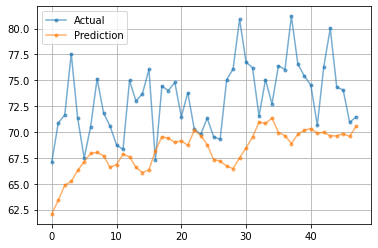

In [53]:
#plot the predictions vs. the actuals
plot_actual_pred( actual[-48:], pred[-48:] )

In [54]:
#predict the validation data set
y_pred = model.predict(X_test)

#scale predictiond and actuals
pred = yScaler.inverse_transform( y_pred[:,[0] ] )
actual = yScaler.inverse_transform( y_test )

#calculate the Mean Squared Error using the scaled values
error = mean_squared_error(pred, actual, squared=False)
print( 'ERROR: {:.4f}'.format(error) )

ERROR: 8.8160


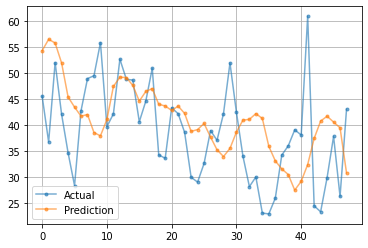

In [55]:
#plot the predictions vs. the actuals
plot_actual_pred( actual[-48:], pred[-48:] )

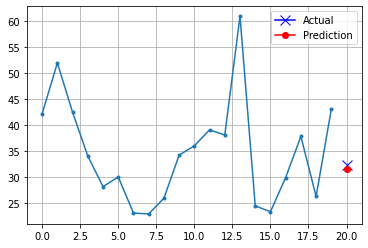

In [56]:
#Predict using the model
y_prediction = model.predict( toPredict )

#scale the y values
y_prediction = yScaler.inverse_transform( y_prediction )

#plot the actual values as well as future known actuals vs. future predictions
#NOTE: if FUTURES is > 1, the ,0 is needed to only plot the 1st value in the prediction
plot_series(actual[-20:], prediction, y_prediction[:,0]) 

In [57]:
#print the error
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

0.6559195709228547